# LCZ Validation Notebook

Notebook created to verify the quality of the classification using testing samples. These samples consist of an external dataset never used during the classification step, in order to check whether the classification produced a good result or not.

The testing samples are always defined by the user and can be imported into this notebook.

The structure is similar to the last part of `5 - Classification.ipynb` notebook. Metrics can be calculated to check the quality of the classification.

### Import libraries

<div class="alert alert-warning" role="alert">
<span>&#9888;</span>
Note: the Notebook relies on the <a href='https://gdal.org/' target='_blank'><em>gdal</em></a> Python library; make sure you have it installed in your environment.
</div>

In [ ]:
import warnings
warnings.filterwarnings("ignore")

import geopandas as gpd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import rasterio
from rasterio.plot import show
from rasterio.mask import mask
import numpy as np
import pandas as pd
import seaborn as sns
import ipywidgets as widgets
from osgeo import gdal, ogr, gdalconst, gdal_array, osr
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from shapely.geometry import box

# Import functions and set auto-reload
from functions import *
%load_ext autoreload
%autoreload 2

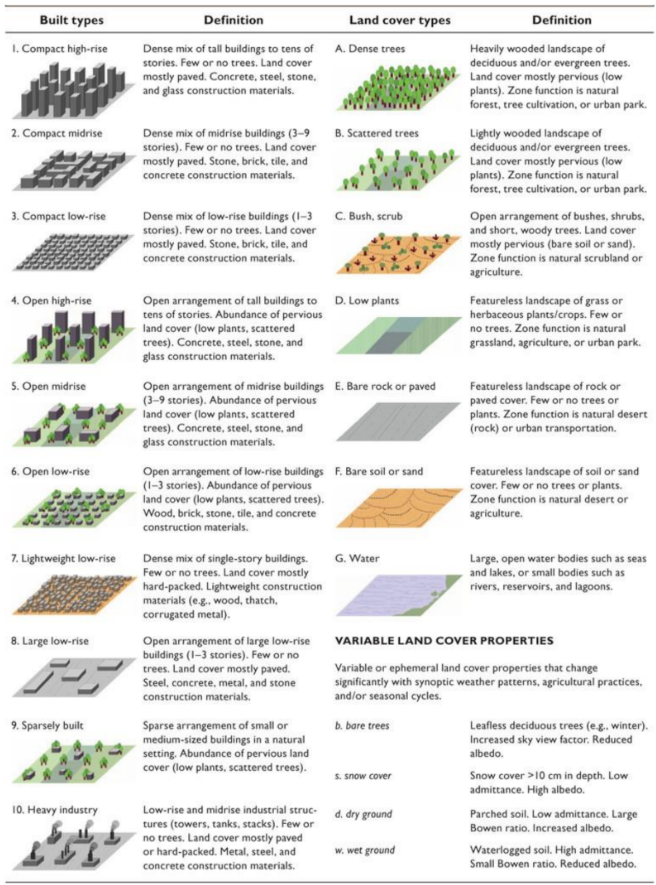

Select the PRISMA image date:

In [ ]:
date_prisma_w = widgets.Dropdown(
    options=['2023-02-09', '2023-03-22', '2023-04-08'],
    value='2023-02-09',
    description='PRISMA date:',
    disabled=False,
    layout={'width': 'max-content'},
    style = {'description_width': 'initial'}
)
date_prisma_w

In [ ]:
sel_prisma_date = date_prisma_w.value
selected_prisma_image = 'PRISMA_outputs/coregistered/PR_'+ sel_prisma_date.replace('-', '') + '_30m.tif'
print(f"The selected date is --> PRISMA: {sel_prisma_date}.")

Read the vector file containing the testing samples:

In [ ]:
# Read in the vector file
vector_LCZ_path = './layers/testing_samples/testing_set_' + sel_prisma_date.replace('-', '') + '.gpkg'
test_data = gpd.read_file(vector_LCZ_path)

# Specify the column to plot
column_name = 'LCZ'

test_data.head()

In [ ]:
total_area = test_data.groupby(column_name)['geometry'].apply(lambda x: x.area.sum())
classes_LCZ = list(test_data.LCZ.unique())
classes_LCZ.sort()
print("LCZ classes: ", classes_LCZ)

In [ ]:
colors_dict = { '2': '#D10000',
                '3': '#CD0000',
                '5': '#FF6600',
                '6': '#FF9955',
                '8': '#BCBCBC',
                '101': '#006A00',
                '102': '#00AA00',
                '104': '#B9DB79',
                '105': '#545454',
                '106': '#FBF7AF',
                '107': '#6A6AFF'}
# Generate a colormap
cmap_colors = [colors_dict[key] for key in colors_dict.keys()]
cmap = plt.cm.colors.ListedColormap(cmap_colors, name='LCZ classes colormap')
cmap

In [ ]:
# Plot a bar plot of the area
plt.bar(total_area.index.astype(str), total_area, color=cmap_colors)
plt.xlabel('Class')
plt.ylabel('Total Area')
plt.show()

In [ ]:
attribute ='LCZ'
output = './layers/testing_samples/testing_set_'+ sel_prisma_date.replace('-', '') + '_30m.tif'
rasterize_shapefile('PCs_20230209_30m.tif',  vector_LCZ_path, output, attribute, projection=32632)

In [ ]:
# Open the raster file
with rasterio.open(output) as src:
    # Read the raster data
    rasterized_result = src.read()
    rasterized_result[np.isnan(rasterized_result)] = 0
    # Convert the data to integer type
    rasterized_result = rasterized_result.astype(np.float32)
    rasterized_result[rasterized_result <= 0] = np.nan
    print(np.unique(rasterized_result))

In [ ]:
bounds = [int(key) for key in colors_dict.keys()]
bounds.append(bounds[-1]+1)
norm = colors.BoundaryNorm(bounds, cmap.N)
# Plot the raster data with a custom figure size
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(1, 1, 1)
show(rasterized_result, cmap=cmap, ax=ax, interpolation='none',norm=norm)
plt.title('Rastarized testing samples')

# Add a legend with the correct class colors
labels = list(colors_dict.keys())
handles = [plt.Rectangle((0, 0), 1, 1, color=colors_dict[label]) for label in labels]
legend = plt.legend(handles, labels, title='LCZ Classes', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.setp(legend.get_title(), fontsize='12')  # Adjust the font size of the legend title

# Adjust the plot layout to accommodate the legend outside
plt.tight_layout(rect=[0, 0, 0.85, 1])  # Increase the left margin to make space for the legend

plt.show()

In [ ]:
with rasterio.open(selected_prisma_image) as src:
    raster_crs = src.crs
    raster_bounds = src.bounds
    
xmin, ymin, xmax, ymax = raster_bounds
bbox_polygon = box(xmin, ymin, xmax, ymax)

bbox_gdf = gpd.GeoDataFrame(geometry=[bbox_polygon], crs=raster_crs)

bbox = 'study_area_' + sel_prisma_date.replace('-', '')+'.gpkg'
bbox_gdf.to_file(bbox)

In [ ]:
prisma_image = rasterio.open(selected_prisma_image)
prisma_image_array = prisma_image.read()
prisma_image_array = prisma_image_array.transpose(1, 2, 0)

In [ ]:
# Mask for coregistered imagery
empty_value = 0  #this is done because scikit learn cannot use nan
mask_prisma = np.amax(prisma_image_array, axis=2).astype(float)
mask_prisma[mask_prisma > 0] = 1
mask_prisma[mask_prisma <= 0] = empty_value
print(f"PRISMA mask shape --> {mask_prisma.shape}")

Create the PRISMA mask:

In [ ]:
plt.imshow(mask_prisma)
plt.colorbar(ticks=[0, 1]);
plt.title("PRISMA mask");

In [ ]:
# Load the GeoPackage vector file
study_area = gpd.read_file(bbox)

In [ ]:
# Testing samples
roi_ds = './layers/testing_samples/testing_set_'+ sel_prisma_date.replace('-', '')+'_30m.tif'
roi_new_path = './layers/testing_samples/testing_set_'+ sel_prisma_date.replace('-', '')+'_30m.tif'
clip_image_study_area(roi_ds, roi_new_path, study_area)

Select the method used for classification to chose the image that want to be tested:

In [ ]:
classification_method_w = widgets.RadioButtons(
    options=['RF', 'XGB', 'AB', 'GB'],  #Random Forest, AdaBoost, GradientBoost
    value='RF', # Defaults to 'pineapple'
    layout={'width': 'max-content'}, # If the items' names are long
    description='Classifier:',
    disabled=False
)
classification_method_w

In [ ]:
classification_method = classification_method_w.value
print(f'Selected classification method: {classification_method}')

In [ ]:
print('Selected image: classified_images/classified_' + classification_method + '_' + sel_prisma_date.replace('-', '') + '_medianfilter_30m.tif')
classified_image = rasterio.open('classified_images/classified_' + classification_method + '_' + sel_prisma_date.replace('-', '') + '_medianfilter_30m.tif')
classified_image = classified_image.read()
print(f"Selected image shape: {classified_image.shape}")

In [ ]:
# Plot the raster data with a custom figure size
fig = plt.figure(figsize=(14, 14))
ax = fig.add_subplot(1, 1, 1)
plt.title(f"Classified LCZ image with {classification_method}")
show(classified_image, cmap=cmap, ax=ax, interpolation='none',norm=norm);

cmap = colors.ListedColormap([colors_dict[key] for key in colors_dict])

# Add a legend with the correct class colors
labels = list(colors_dict.keys())
handles = [plt.Rectangle((0, 0), 1, 1, color=colors_dict[label]) for label in labels]
legend = plt.legend(handles, labels, title='LCZ Classes', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.setp(legend.get_title(), fontsize='12')  # Adjust the font size of the legend title

# Adjust the plot layout to accommodate the legend outside
plt.tight_layout(rect=[0, 0, 0.85, 1])  # Increase the left margin to make space for the legend

plt.show()

Read the testing samples to validate the result:

In [ ]:
testing_samples = rasterio.open(roi_new_path)
testing_samples = testing_samples.read()
print(f"Testing samples shape: {testing_samples.shape}")

In [ ]:
bounds = [int(key) for key in colors_dict.keys()]
bounds.append(bounds[-1]+1)
norm = colors.BoundaryNorm(bounds, cmap.N)
# Plot the raster data with a custom figure size
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(1, 1, 1)
show(rasterized_result, cmap=cmap, ax=ax, interpolation='none',norm=norm)
plt.title('Testing samples clipped over the study area')

# Add a legend with the correct class colors
labels = list(colors_dict.keys())
handles = [plt.Rectangle((0, 0), 1, 1, color=colors_dict[label]) for label in labels]
legend = plt.legend(handles, labels, title='LCZ Classes', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.setp(legend.get_title(), fontsize='12')  # Adjust the font size of the legend title

# Adjust the plot layout to accommodate the legend outside
plt.tight_layout(rect=[0, 0, 0.85, 1])  # Increase the left margin to make space for the legend

plt.show()

In [ ]:
# Retrieve the indices where testing_samples is greater than 0
x, y, z = np.where(testing_samples>0)

# Select the testing samples that are greater than 0
test_samples = testing_samples[testing_samples > 0]
# Extract the corresponding classified samples from classified_image using the indices
classified_samples = classified_image[x, y, z]

# Retrieve the indices where classified_samples are greater than 0 and not NaN
a = np.where((classified_samples > 0) & (~np.isnan(classified_samples)))

# Filter the test_samples and classified_samples based on the indices obtained
test_samples = test_samples[a]
classified_samples = classified_samples[a]

print('Test samples shape:', test_samples.shape)
print('Classified samples shape:', classified_samples.shape)

In [ ]:
# Calculate the accuracy of the best model on the test set
accuracy = accuracy_score(test_samples, classified_samples)
print(f"Accuracy: {accuracy:.3f}")

**Accuracy**: It gives you the overall accuracy of the model, meaning the fraction of the total samples that were correctly classified by the classifier. To calculate accuracy, use the following formula: $(TP+TN)\over(TP+TN+FP+FN)$.

**Precision**: It tells you what fraction of predictions as a positive class were actually positive. To calculate precision, use the following formula: $TP\over(TP+FP)$.

**Recall**: It tells you what fraction of all positive samples were correctly predicted as positive by the classifier. It is also known as True Positive Rate (TPR), Sensitivity, Probability of Detection. To calculate Recall, use the following formula: $TP\over(TP+FN)$.

**F1-score**: It combines precision and recall into a single measure. Mathematically it’s the harmonic mean of precision and recall. Formula: $2 * (Precision*Recall)\over(Precision+Recall)$

**Support**: number of occurrences of each class in y_true.

In [ ]:
print_metrics(test_samples, classified_samples)